## Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

root = './Datasets/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3_x,is_reorder_2_x,...,reorder_proportion_by_user,department_unique_users_y,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4542.121519088745  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1244.6383724212646  MB
This is  27.402137243368337 % of the initial size


In [6]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [7]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3_x,is_reorder_2_x,is_reorder_1_x,is_reorder_3_y,...,department_unique_users_y,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,0.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474661 entries, 0 to 8474660
Data columns (total 72 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   total_product_orders_by_user       float16
 1   total_product_reorders_by_user     float16
 2   user_product_reorder_percentage    float16
 3   avg_add_to_cart_by_user            float16
 4   avg_days_since_last_bought         float16
 5   last_ordered_in                    float16
 6   is_reorder_3_x                     float16
 7   is_reorder_2_x                     float16
 8   is_reorder_1_x                     float16
 9   is_reorder_3_y                     float16
 10  is_reorder_2_y                     float16
 11  is_reorder_1_y                     float16
 12  order_number                       float16
 13  order_dow                          float16
 14  order_hour_of_day                  float16
 15  days_since_prior_order             float16
 16  reordered         

In [8]:
df.shape

(8474661, 72)

In [9]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [10]:
X = df[x_cols]
y = df[label]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 71) (6355995,)
(2118666, 71) (2118666,)


In [19]:
y_train.value_counts()

reordered
0.0    5734377
1.0     621618
Name: count, dtype: int64

In [20]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [21]:
y_test.value_counts()

reordered
0.0    1911460
1.0     207206
Name: count, dtype: int64

In [22]:
# freeing memory
del df, X, y
gc.collect()

304

### Neural Network model

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2

In [35]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [36]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train_resampled)
X_test_sc = sc.transform(X_test)

In [37]:
input_dim =  X_train_sc.shape[1]
input_dim

71

In [38]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [39]:
classifier = Sequential()
classifier.add(Dense(units=128, activation='relu', input_dim=input_dim,kernel_regularizer=l2(0.001))) 
classifier.add(Dense(units=64, activation='relu',kernel_regularizer=l2(0.001)))
classifier.add(Dense(units=32, activation='relu',kernel_regularizer=l2(0.001)))
classifier.add(Dense(units=1, activation='sigmoid',kernel_regularizer=l2(0.001)))
classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

history = classifier.fit(X_train_sc, y_train_resampled, epochs=50, batch_size=512, validation_split=0.15, verbose=1,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])
classifier.summary()

C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.8323 - f1_m: 0.7781 - loss: 0.4301 - precision_m: 0.8549 - recall_m: 0.7183 - val_accuracy: 0.8405 - val_f1_m: 0.9132 - val_loss: 0.3470 - val_precision_m: 1.0000 - val_recall_m: 0.8405
Epoch 2/50
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.8516 - f1_m: 0.8042 - loss: 0.3795 - precision_m: 0.8790 - recall_m: 0.7440 - val_accuracy: 0.7643 - val_f1_m: 0.8663 - val_loss: 0.4708 - val_precision_m: 1.0000 - val_recall_m: 0.7643
Epoch 3/50
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.8534 - f1_m: 0.8066 - loss: 0.3772 - precision_m: 0.8818 - recall_m: 0.7459 - val_accuracy: 0.7676 - val_f1_m: 0.8684 - val_loss: 0.4588 - val_precision_m: 1.0000 - val_recall_m: 0.7676
Epoch 4/50
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - accuracy: 0.8550 - f1_m: 0.8085 - loss: 0.3758 - precision_m: 0.8844 - recall_m: 0.7472 - val_accuracy: 0.7769 - val_f1_m: 0.8743 - val_loss: 0.4411 - val_precision_m: 1.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 128)                 │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,757 (229.52 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,172 (153.02 KB)

In [40]:
eval_model = classifier.evaluate(X_test_sc, y_test)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])


66209/66209 ━━━━━━━━━━━━━━━━━━━━ 55s 837us/step - accuracy: 0.8931 - f1_m: 0.3436 - loss: 0.3600 - precision_m: 0.4113 - recall_m: 0.3447
loss:  0.3604486286640167 and Accuracy:  0.8929194211959839


In [41]:
print(history.history.keys())


dict_keys(['accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_accuracy', 'val_f1_m', 'val_loss', 'val_precision_m', 'val_recall_m'])


Text(0.5, 1.0, 'Loss')

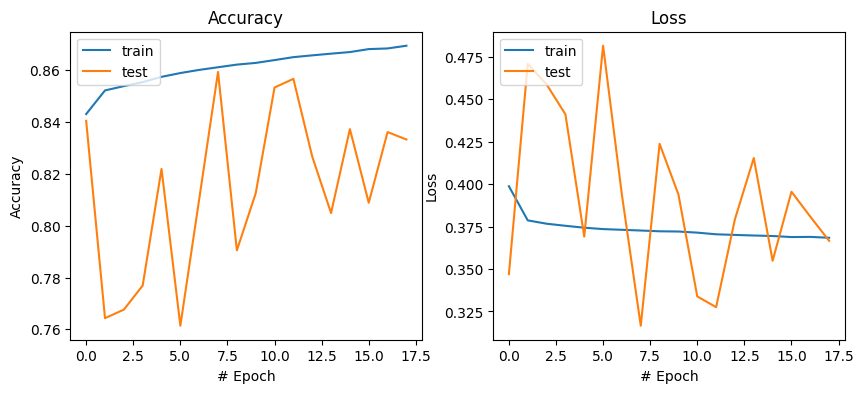

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')

66209/66209 ━━━━━━━━━━━━━━━━━━━━ 53s 796us/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94   1911460
         1.0       0.44      0.36      0.40    207206

    accuracy                           0.89   2118666
   macro avg       0.69      0.65      0.67   2118666
weighted avg       0.88      0.89      0.89   2118666

Accuracy Score :  0.8929194124982418
F1 Score:  0.8878416157696853
Area under curve :  0.8085070688854281 



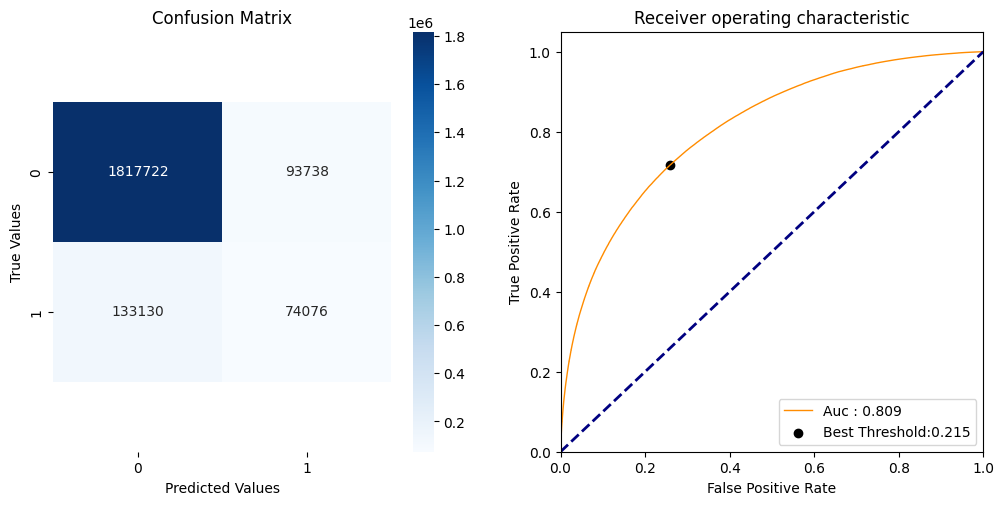

In [43]:
probabilities = classifier.predict(X_test_sc)
predictions = (probabilities > 0.5).astype(int)  # Thresholding at 0.5

print("\n Classification report : \n", classification_report(y_test, predictions))
print("Accuracy Score : ", accuracy_score(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

# F1-score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score: ", f1)
# ROC curve and AUC
model_roc_auc = roc_auc_score(y_test, probabilities)
print("Area under curve : ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="Auc : %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()